# Lab 5 Part 3 - Serious Liar's Dice

In Part 2, all AI players have the same prompt. If you wanted to compare between models, you could only compare between the Gemini family. Let's include more model providers in the mix.

Set up an API key from [openrouter.ai](https://openrouter.ai/). Create an account, and in Settings -> Privacy, toggle on `Enable providers that may train on inputs` under Paid Models and toggle on `Enable training and logging (chatroom and API)` under Free Models. This will allow you to use some models for free at a low rate in exchange of your chat data being used for model training. I believe that is acceptable for the purposes of this lab. In general however, please be wary about passing your own data to LLM providers.

Add the API key to your `.env` like so:

```
# .env
GOOGLE_API_KEY=your-api-key-here
OPENROUTER_API_KEY=your-api-key-here
```

On top of the packages in the Telephone Game notebook, ensure `langchain-openai` is installed.

Here is an example of how you can run free models from [openrouter.ai](https://openrouter.ai/).

```python
from langchain_openai import ChatOpenAI

llama3_3 = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=config("OPENROUTER_API_KEY"),
    model="meta-llama/llama-3.3-8b-instruct:free",
)

chain = (
    ChatPromptTemplate.from_template("Generate a limerick based on: {theme}") | llama3_3 | StrOutputParser()
)

chain.invoke({"theme": "bananas"})
# 'There once was a banana so bright,\nGrew in the tropics with warm delight.\nIt ripened with care,\nAnd was eaten with flair,\nAnd its taste was a pure pleasure in sight!'
```

## Making a serious Liar's Dice game

Go ahead and set up a Liar's Dice game where we pit free models against each other. Use the following:

- "meta-llama/llama-3.3-8b-instruct:free"
- "google/gemma-3-12b-it:free"
- "mistralai/mistral-small-3.1-24b-instruct:free"
- "qwen/qwen3-8b:free"

Note that for qwen3 models, you need to use /nothink in the prompt to prevent it from going into reasoning mode, as it will spend too much of your free limit and will be very slow to return results. Example code:

```python
qwen3_8b = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=config("OPENROUTER_API_KEY"),
    model="qwen/qwen3-8b:free",
)
chain = (
    ChatPromptTemplate.from_template("/nothink Generate a limerick based on: {theme}")
    | qwen3_8b | StrOutputParser()
)
```

In [1]:
# Your work below
import time
import re
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from decouple import Config, RepositoryEnv
from langchain_openai import ChatOpenAI

from liarsdice import LiarsDiceGame
from player import AIPlayer  # This is the AIPlayer class from part 2, with little modifications to support "/nothink"

In [2]:
config = Config(RepositoryEnv(".env"))
OPENROUTER_API_KEY = config("OPENROUTER_API_KEY")

In [3]:
class GameObserver:
    """Record game statistics"""
    def __init__(self, game: LiarsDiceGame):
        self.game = game
        self.records = []
        self.players = []
        self.dice = []
        self.history_offset = 0

        self._record_players_and_dice()

    def record(self):
        # A round in the game always ends with CHALLENGE_RESULT
        if self._parse_history_log(self.game.history[-1])[0] != "CHALLENGE_RESULT":
            return
        
        self.records.append({
            "players": self.players,
            "dice": self.dice,
            "turns": self._parse_turns(),
        })
        self._record_players_and_dice()

    def save_json(self, base_dir: str = "./game_records/"):
        base_path = Path(base_dir)
        os.makedirs(base_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        filename = f"{timestamp}.json"
        with open(base_path / filename, "w", encoding="utf-8") as f:
            json.dump(self.records, f, ensure_ascii=False, indent=4)

    def _record_players_and_dice(self):  # Should record at the start of each round
        self.players = []
        self.dice = []

        for name, data in self.game.players.items():
            if data["dice"]:
                self.players.append(name)
                self.dice.append(deepcopy(data["dice"]))

    @staticmethod
    def _parse_history_log(text):
        patterns = [
            (r"^(?P<player>.+?) bids (?P<quantity>\d+) dice show (?P<face_value>\d+)(?P<corrected> \(auto-corrected\))?$", "BID"),
            (r"^(?P<challenger>.+?) challenges (?P<bidder>.+?)'s bid$", "CHALLENGE"),
            (r"^Challenge: (?P<challenger>.+?) vs (?P<bidder>.+?) - (?P<winner>.+?) wins$", "CHALLENGE_RESULT")
        ]
        for pattern, action_type in patterns:
            match = re.match(pattern, text)
            if match:
                return action_type, match.groupdict()
        raise RuntimeError(f"Fail to parse '{text}'")

    def _parse_turns(self):
        turns = []
        challenger, bidder = None, None
        
        history_texts = self.game.history[self.history_offset:]
        for history_text in history_texts:
            type_, data = self._parse_history_log(history_text)
            if type_ == "BID":
                turns.append({
                    "parameters": [int(data["quantity"]), int(data["face_value"])],
                    "auto_corrected": data["corrected"] is None,
                    "win_challenge": None,
                })
            elif type_ == "CHALLENGE":
                challenger, bidder = data["challenger"], data["bidder"]
            elif type_ == "CHALLENGE_RESULT":
                winner = data["winner"]
                assert winner == challenger or winner == bidder, f"Unknown winner: {winner}, expect '{challenger}' or '{bidder}'"
                
                turns.append({
                    "parameters": None,
                    "auto_corrected": False,
                    "win_challenge": winner == challenger,
                })
                challenger, bidder = None, None
            else:
                raise RuntimeError(f"Cannot handle history record: '{history_text}'")
            self.history_offset += 1
        
        assert challenger is None and bidder is None, "There is a challenge without verdict"
        return turns

In [4]:
def play(players, *, dice_per_player=3, max_turns=50, verbose=True):
    game = LiarsDiceGame()
    game.setup_game(players, dice_per_player=dice_per_player)
    observer = GameObserver(game)

    # Play game
    turn_count = 0
    while turn_count < max_turns:
        if verbose:
            print(f"\n{'--- TURN ' + str(turn_count + 1) + ' ---':^60}")
    
        game_ended = not game.play_turn()
        observer.record()
        if game_ended:
            break
    
        turn_count += 1
    
        if verbose:
            time.sleep(2)  # Pause for readability

    observer.save_json()
    if verbose:
        if turn_count >= max_turns:
            print("\nGame ended due to turn limit")
        
        print(f"\nGame finished after {turn_count} turns!")
        print("Final game history:")
        for i, action in enumerate(game.history, 1):
            print(f"   {i}. {action}")

In [5]:
players = [
    AIPlayer(
        name="Llama",
        llm=ChatOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=config("OPENROUTER_API_KEY"),
            model="meta-llama/llama-3.3-8b-instruct:free",
        ),
    ),
    AIPlayer(
        name="Gemma",
        llm=ChatOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=config("OPENROUTER_API_KEY"),
            model="google/gemma-3-12b-it:free",
        ),
    ),
    AIPlayer(
        name="Mistral",
        llm=ChatOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=config("OPENROUTER_API_KEY"),
            model="mistralai/mistral-small-3.1-24b-instruct:free",
        ),
    ),
    AIPlayer(
        name="Qwen",
        llm=ChatOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=config("OPENROUTER_API_KEY"),
            model="qwen/qwen3-8b:free",
        ),
        prompt_prefix="/nothink",
    ),
]

[Llama] LLM initialized with system prompt. Response: OK
[Gemma] LLM initialized with system prompt. Response: OK

[Mistral] LLM initialized with system prompt. Response: OK.
[Qwen] LLM initialized with system prompt. Response: OK.


In [6]:
play(players, dice_per_player=2)

LIAR'S DICE!
Players: Llama, Gemma, Mistral, Qwen
Total dice: 8

DICE (not visible to players):
Llama: [4, 2]
Gemma: [1, 3]
Mistral: [4, 5]
Qwen: [3, 4]

                       --- TURN 1 ---                       

ROUND 1 - GAME STATE
PLAYERS:
   Llama: [4, 2] (2 dice) ← CURRENT TURN
   Gemma: [1, 3] (2 dice)
   Mistral: [4, 5] (2 dice)
   Qwen: [3, 4] (2 dice)

CURRENT BID: None (round start)

📊 TOTAL DICE IN PLAY: 8

Llama's turn
[Llama] Player's thoughts: To make a strategic start, I should bid on a number of dice and a face value that gives me a decent chance of winning, while also being mindful of the potential risks and rewards. Considering there are 8 dice in total and my private dice shows [4, 2], I want to start with a bid that is ambitious but realistic.

Given the lack of information about the other players' dice, I need to make an educated guess. A moderate approach would be to bid on a smaller number of dice to begin with, allowing for flexibility in case my initial bid 

## EX: Measuring LLM capability

How does each LLM measure up to each other when it comes to playing Liar's Dice? Track the necessary stats over multiple rounds of play and give your analysis based on that data.

---

The code above is run 20 times, and 20 JSON files are collected.

In [7]:
# Your work below
game_data = []
for game_filepath in Path("./game_records").glob("*.json"):
    with open(game_filepath, 'r') as f:
        game_data.append(json.load(f))

In [8]:
def rank_players(game_data):
    ranked = []

    # Add eliminated players iteratively
    last_round_players = game_data[0]["players"]
    for game_round in game_data[1:]:
        this_round_players = game_round["players"]
        eliminated = set(last_round_players) - set(this_round_players)
        assert len(eliminated) <= 1, f"More than one player is eliminated in a round: {eliminated}"
        ranked.extend(eliminated)
        
        last_round_players = this_round_players

    # Check who is the champion
    assert len(last_round_players) == 2, f"Final round should have only 2 players, got {last_round_players}"
    
    tmp = (len(game_data[-1]["turns"]) - 1) % 2  # last index in turns mod 2
    challenger = last_round_players[tmp]
    bidder = last_round_players[(tmp + 1) % 2]
    
    win_challenge = game_data[-1]["turns"][-1]["win_challenge"]  # Does challenger win the challenge?
    assert win_challenge is not None, "The game should end with a CHALLENGE"

    if win_challenge:
        ranked.extend([bidder, challenger])
    else:
        ranked.extend([challenger, bidder])
    return ranked  # Champion goes last

In [9]:
all_ranks = [rank_players(g) for g in game_data]

In [10]:
player_ranks = dict((p, np.zeros(len(all_ranks[0]), dtype=np.uint8)) for p in all_ranks[0])
for p in player_ranks.keys():
    for ranks in all_ranks:
        player_ranks[p][len(player_ranks) - ranks.index(p) - 1] += 1
player_ranks  # player_name: [count_1st, count_2nd, ...]

{'Mistral': array([ 3,  3,  2, 12], dtype=uint8),
 'Llama': array([6, 6, 6, 2], dtype=uint8),
 'Qwen': array([8, 4, 6, 2], dtype=uint8),
 'Gemma': array([3, 7, 6, 4], dtype=uint8)}

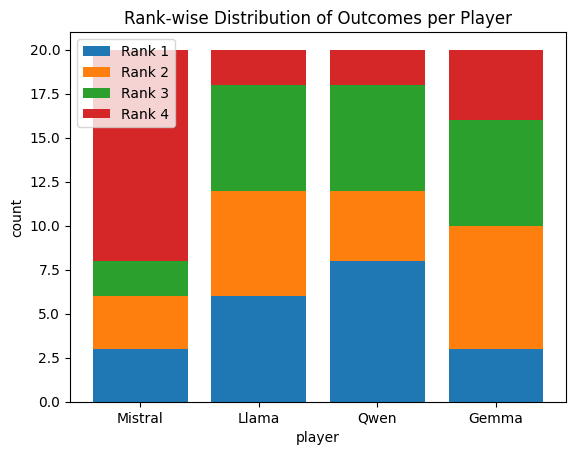

In [11]:
labels = player_ranks.keys()
x = np.arange(len(labels))

segments = []
for i in range(len(labels)):
    segments.append([player_ranks[p][i] for p in labels])

bottom = np.zeros_like(x)
for rank, segment in enumerate(segments, 1):
    plt.bar(x, segment, bottom=bottom, label=f"Rank {rank}")
    bottom += segment

plt.xticks(x, labels)
plt.xlabel("player")
plt.ylabel("count")
plt.title("Rank-wise Distribution of Outcomes per Player")
plt.legend();

In [12]:
player_scores = dict()
for p, ranks in player_ranks.items():
    player_scores[p] = (ranks * np.arange(len(ranks), 0, -1)).sum()  # last = 1, second last = 2, ..., champion = n
player_scores

{'Mistral': 37, 'Llama': 56, 'Qwen': 58, 'Gemma': 49}

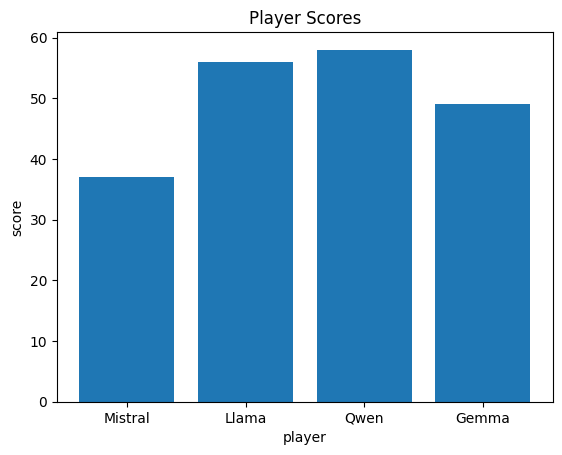

In [13]:
plt.bar(x, player_scores.values())
plt.xticks(x, labels)
plt.xlabel("player")
plt.ylabel("score")
plt.title("Player Scores");

In [14]:
def decision_breakdowns(game_data):
    breakdowns = {}  # player_name -> [challenge_fail, challenge_success, challenge_miss, auto_corrected, total]
    for game in game_data:
        for game_round in game:
            for idx, turn in enumerate(game_round["turns"]):
                player = game_round["players"][idx % len(game_round["players"])]
                breakdowns.setdefault(player, np.zeros((5, ), dtype=np.int32))
                breakdowns[player][4] += 1
                
                if turn["auto_corrected"]:
                    breakdowns[player][3] += 1
                    continue  # Auto-corrected challenges do not count into the first three fields
        
                if turn["win_challenge"] is not None:
                    breakdowns[player][int(turn["win_challenge"])] += 1
                    
                if idx > 0 and turn["win_challenge"] is None:
                    all_dice = sum(game_round["dice"], [])  # Flatten list of lists
                    prev_bid = game_round["turns"][idx - 1]["parameters"]
                    assert len(prev_bid) == 2, f"A player is challenging to no bid, or the format is not recognized: {prev_bid}"
        
                    bid_count, face_value = prev_bid
                    real_count = len(list(filter(lambda dice: dice in (face_value, 1), all_dice)))
                    if bid_count > real_count:  # Is a bluff
                        breakdowns[player][2] += 1
    return breakdowns

In [15]:
all_breakdowns = decision_breakdowns(game_data)
all_breakdowns

{'Llama': array([ 12,  15,  10, 125, 167]),
 'Gemma': array([ 33,  17,  11,  51, 126]),
 'Mistral': array([18, 11,  9, 33, 75]),
 'Qwen': array([ 8, 17, 10, 24, 73])}

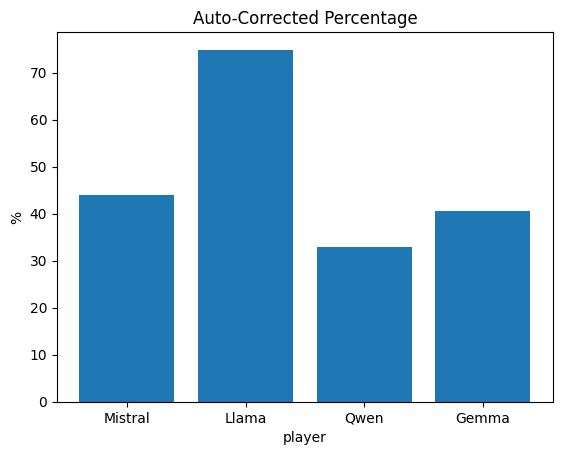

In [16]:
plt.bar(x, [all_breakdowns[p][3] / all_breakdowns[p][-1] * 100 for p in labels])

plt.xticks(x, labels)
plt.xlabel("player")
plt.ylabel("%")
plt.title("Auto-Corrected Percentage");

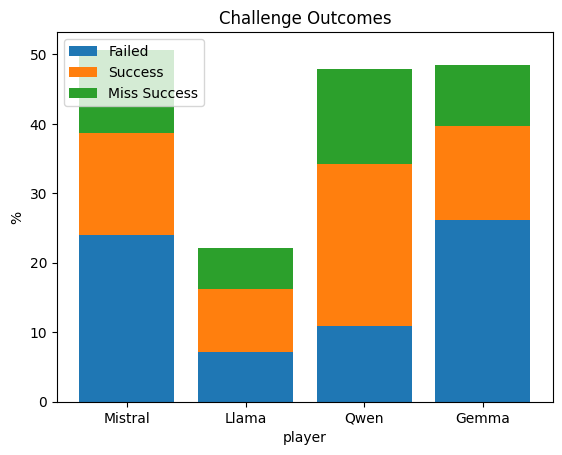

In [17]:
segments = []
for i in range(3):
    segments.append([all_breakdowns[p][i] / all_breakdowns[p][-1] * 100 for p in labels])

bottom = np.zeros_like(x.astype(np.float32))
for segment_label, segment in zip(("Failed", "Success", "Miss Success"), segments):
    plt.bar(x, segment, bottom=bottom, label=f"{segment_label}")
    bottom += segment

plt.xticks(x, labels)
plt.xlabel("player")
plt.ylabel("%")
plt.title("Challenge Outcomes")
plt.legend();

Note 1: *“Miss Success”* refers to how often a player missed the opportunity to catch an opponent's bluff.

Note 2: The percentages shown are calculated based on the total number of moves made by each player.

### My analysis

Qwen >> Gemma > Mistral >> Llama.

| Player  | Comments |
|---|---|
| Qwen | Achieved the highest overall score with the fewest invalid moves and demonstrated strong decision-making during challenges. |
| Gemma | Performed well overall but showed a low success rate when initiating challenges. |
| Mistral | Consistently ranked poorly and made frequent mistakes during challenges. |
| Llama | Despite a high overall score, it had the highest rate of invalid moves—nearly double that of the others. In a small setup (`dice_per_player=2`), these auto-corrected decisions often happen to work out well. Tends to avoid challenges, possibly influenced by auto-correction also. |